# Datasets

## Flickr-Faces-HQ Dataset (FFHQ)  
https://github.com/NVlabs/ffhq-dataset

A Style-Based Generator Architecture for Generative Adversarial Networks  
Tero Karras (NVIDIA), Samuli Laine (NVIDIA), Timo Aila (NVIDIA)  
https://arxiv.org/abs/1812.04948

## FFHQ-Aging Dataset  
https://github.com/royorel/FFHQ-Aging-Dataset

Lifespan Age Transformation Synthesis  
Roy Or-El, Soumyadip Sengupta, Ohad Fried, Eli Shechtman, Ira Kemelmacher-Shlizerman  
ECCV 2020  
https://arxiv.org/pdf/2003.09764.pdf

In [ ]:
from google.colab import drive
drive.mount('/content/GDrive', force_remount=True)

Mounted at /content/GDrive


In [ ]:
# For Dwij
cloud_root = "/content/GDrive/MyDrive/5th Semester (20 BCE 070)/Innovative/2CS501 ML"
local_root = "/content/local"

# For Others
# Create a shortcut to shared folder in your drive
# cloud_root = "path/to/shortcut"
# local_root = "path/to/local/folder"

In [ ]:
cloud_dataset = f"{cloud_root}/FFHQ.zip"
local_dataset = f"{local_root}/Dataset"

metadata_csv = f"{local_dataset}/metadata.csv"

encoder_checkpoint = f"{cloud_root}/Model/FFHQ_encoder.pickle"
pca_checkpoint = f"{cloud_root}/Model/FFHQ_pca.pickle"
scaler_checkpoint = f"{cloud_root}/Model/FFHQ_scaler.pickle"
model_checkpoint = f"{cloud_root}/Model/FFHQ_model.pickle"

In [ ]:
# For extracting cloud dataset to colab instance

!mkdir -p "$local_dataset"
!unzip -qq "$cloud_dataset" -d "$local_dataset/"

# Load Dataset

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import numpy as np
import cv2

import time

import pickle

In [ ]:
metadata = pd.read_csv(
    metadata_csv,
    index_col = 'image_number',
    usecols=["image_number", "gender"]
)
encoder = LabelEncoder()
encoder.fit(metadata["gender"])

with open(encoder_checkpoint, "wb") as f:
    pickle.dump(encoder, f)

dataset_size = len(metadata)
resolution = cv2.imread(
    f"{local_dataset}/00000/00000.png",
    cv2.IMREAD_COLOR
).shape
pixels = np.prod(resolution)

dataset = np.memmap(
    f"{local_root}/memmap.dat",
    dtype=np.uint8,
    mode='w+',
    shape=(dataset_size, pixels)
)

In [ ]:
verbose = 10
end = None
begin = time.time()

for iter, d in enumerate(range(0, dataset_size, 1000)):
    if iter % verbose == 0:
        print(f"\r[read] {100 * d // dataset_size}% ...", end = "")
        if end != None:
            print(f" ETA {end * (dataset_size - d):.2f}s", end = "")

    for i in range(d, d + 1000):
        dataset[i, :] = np.ravel(cv2.imread(
            f"{local_dataset}/{d:05}/{i:05}.png",
            cv2.IMREAD_COLOR
        ))

    if iter == 0:
        end = (time.time() - begin) / 1000

print(f"\r[read] 100%")

[read] 100%


In [ ]:
print("Total images:", dataset_size)
print("Image resolution:", resolution)
print("Pixels per image:", pixels)
print("Dataset size: {0:.2f} GiB".format(dataset.nbytes / 1024**3))

Total images: 70000
Image resolution: (128, 128, 3)
Pixels per image: 49152
Dataset size: 3.20 GiB


# Principle Component Analysis
## Eigen Faces

In [ ]:
from sklearn.decomposition import IncrementalPCA as PCA

In [ ]:
def extract_eigenfaces(data, pca_components = 200, batch_size = 300):
    batch_size = min(1.5 * pca_components, batch_size)

    pca = PCA(n_components = pca_components)

    verbose = 10
    end = None
    begin = time.time()

    splits = np.array_split(data, np.ceil(len(data) / batch_size))
    for iter, indices in enumerate(splits):
        if iter % verbose == 0:
            print(f"\r[process] {100 * iter // len(splits)}% of {len(splits)} batches ...", end = "")
            if end != None:
                print(f" ETA {end * (len(splits) - iter):.2f}s", end = "")

        pca.partial_fit(dataset[indices])

        if iter == 0:
            end = (time.time() - begin)

    print(f"\rExtracted {pca.n_components_} components")
    return pca

## Checkpoint

In [ ]:
with open(pca_checkpoint, "rb") as f:
    dataset_pca = pickle.load(f)

In [ ]:
# dataset_pca = extract_eigenfaces(metadata.index)

Extracted 200 components


In [ ]:
# with open(pca_checkpoint, "wb") as f:
#     pickle.dump(dataset_pca, f)

# Transform inputs

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def pca_transform(X):
    verbose = 10
    end = None
    begin = time.time()

    X_transformed = np.empty((len(X), dataset_pca.n_components_))
    batch_size = 300

    splits = np.array_split(X, np.ceil(len(X) / batch_size))
    index = 0
    for iter, indices in enumerate(splits):
        if iter % verbose == 0:
            print(f"\r[process] {100 * iter // len(splits)}% of {len(splits)} batches ...", end = "")
            if end != None:
                print(f" ETA {end * (len(splits) - iter):.2f}s", end = "")

        X_transformed[index:(index + len(indices))] = dataset_pca.transform(dataset[indices])
        index += len(indices)
    
        if iter == 0:
            end = (time.time() - begin)

    print("\r[process] 100%")

    return X_transformed

In [ ]:
X_transformed = pca_transform(metadata.index)

print(f"Old dataset size: {dataset[metadata.index].shape}")
print(f"Transformed dataset size: {X_transformed.shape}")

[process] 100%
Old dataset set size: (70000, 49152)
Transformed datasset set size: (70000, 200)


In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_transformed)

X_scaled = scaler.transform(X_transformed)

In [ ]:
with open(scaler_checkpoint, "wb") as f:
    pickle.dump(scaler, f)

# Model

In [ ]:
from sklearn.ensemble import VotingClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [ ]:
model = VotingClassifier(
    estimators=[
        ("SVMC", SVC(probability = True, C = 5, gamma = "auto", kernel = "rbf", max_iter = 100000)),
        ("LOGISTIC", LogisticRegression(max_iter = 40000, solver = "newton-cg")),
        ("KNN", KNeighborsClassifier(algorithm = "auto", n_neighbors = 15, weights = "distance")),
        ("CNB", ComplementNB(alpha=5))
    ],
    voting='soft'
)

@ignore_warnings(category=ConvergenceWarning)
def fit():
    model.fit(X_scaled, encoder.transform(metadata["gender"]))
fit()

# Testing

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 100

In [ ]:
predictions = encoder.inverse_transform(model.predict(X_scaled))

Classification Report: 
              precision    recall  f1-score   support

      female       0.93      0.95      0.94     37830
        male       0.94      0.92      0.93     32170

    accuracy                           0.93     70000
   macro avg       0.93      0.93      0.93     70000
weighted avg       0.93      0.93      0.93     70000



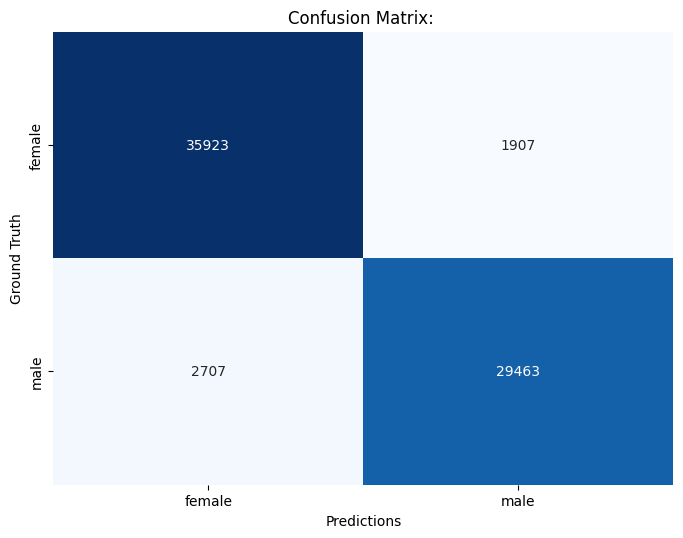

In [ ]:
# Performance Metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Classification Report: ")
print(classification_report(metadata, predictions, target_names = encoder.classes_, zero_division = 0))

conf = pd.DataFrame(confusion_matrix(metadata, predictions), columns = encoder.classes_, index = encoder.classes_)
sns.heatmap(conf, annot = True, fmt='g', cmap='Blues', cbar = False)
plt.title("Confusion Matrix: ")
plt.xlabel("Predictions")
plt.ylabel("Ground Truth");

# Checkpoint

In [ ]:
with open(model_checkpoint, "wb") as f:
    pickle.dump(model, f)